In [59]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
from nsepy import get_history
import matplotlib.pyplot as plt
from ta.trend import EMAIndicator
from keras.models import Sequential
from ta.momentum import RSIIndicator 
from ta.volatility import BollingerBands
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Data Fetching

In [60]:
stock_name = input('Enter NSE Stock Name: ').upper()
date_entry = input('Enter a date in yyyy,m,d format')
year, month, day = map(int, date_entry.split(','))
start_date= datetime.date(year, month, day)
end_date = date.today()
# get_history(symbol = 'SBIN', start=date(2015,1,1), end=date(2022,3,1))
def stock_df(s, sd, ed):
    df = get_history(symbol=s, start=sd, end=ed)
    return df

In [61]:
data = stock_df(stock_name, start_date, end_date)
data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-05-02,SBIN,EQ,309.95,308.05,311.4,305.65,307.90,308.15,308.36,16640100,5.131073e+14,115380,3938300,0.2367
2019-05-03,SBIN,EQ,308.15,309.00,311.8,308.80,309.70,310.00,310.33,12452689,3.864468e+14,128941,3818789,0.3067
2019-05-06,SBIN,EQ,310.00,306.80,310.3,305.90,308.60,308.75,308.38,10639216,3.280894e+14,75642,2793193,0.2625
2019-05-07,SBIN,EQ,308.75,310.70,313.4,303.75,305.20,305.45,310.07,15219845,4.719207e+14,112752,4406362,0.2895
2019-05-08,SBIN,EQ,305.45,303.95,305.3,296.75,298.45,298.25,301.51,22103678,6.664560e+14,125035,7179988,0.3248


Feature Selection and Extaction

In [62]:
df = data[['Open', 'High', 'Low', 'Close', 'Volume']]
df.reset_index(inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.head()

C:\Users\chinn\AppData\Local\Temp\ipykernel_20864\3798465441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Date'], axis=1, inplace=True)


,Open,High,Low,Close,Volume
0,308.05,311.4,305.65,308.15,16640100
1,309.00,311.8,308.80,310.00,12452689
2,306.80,310.3,305.90,308.75,10639216
3,310.70,313.4,303.75,305.45,15219845
4,303.95,305.3,296.75,298.25,22103678


Train Test Split

In [63]:
train_df = pd.DataFrame(df.Close[0:int(len(df.Close)*0.75)])
test_df = pd.DataFrame(df.Close[int(len(df.Close)*0.75):int(len(df))])
train_df.shape, test_df.shape

((583, 1), (195, 1))

In [64]:
train_df.head()

,Close
0,308.15
1,310.00
2,308.75
3,305.45
4,298.25


In [65]:
test_df.head()

,Close
583,431.05
584,429.10
585,431.35
586,432.30
587,432.85


Feature Scaling

In [66]:
scaler = minmax_scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.fit_transform(test_df)

X_train, y_train split

In [67]:
X_train = []
y_train = []
for i in range(100, len(train_df_scaled)):
    X_train.append(train_df_scaled[i-100 : i])
    y_train.append(train_df_scaled[i, 0])
len(X_train), len(y_train)

(483, 483)

In [68]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((483, 100, 1), (483,))

Model building and training

In [69]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, 
                input_shape=(X_train.shape[1], 1))) # input_shape=(timesteps, features)
model.add(Dropout(0.2))
#layer 2
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
#layer 3
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.4))
#layer 4
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units = 1))


In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 128)          66560     
                                                                 
 dropout_4 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 100)          91600     
                                                                 
 dropout_5 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 60)           38640     
                                                                 
 dropout_6 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_7 (LSTM)               (None, 60)               

In [71]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=69)

Epoch 1/50
7/7 [==============================] - 6s 325ms/step - loss: 0.1112
Epoch 2/50
7/7 [==============================] - 2s 353ms/step - loss: 0.0516
Epoch 3/50
7/7 [==============================] - 2s 344ms/step - loss: 0.0330
Epoch 4/50
7/7 [==============================] - 2s 315ms/step - loss: 0.0308
Epoch 5/50
7/7 [==============================] - 2s 322ms/step - loss: 0.0236
Epoch 6/50
7/7 [==============================] - 2s 312ms/step - loss: 0.0196
Epoch 7/50
7/7 [==============================] - 2s 315ms/step - loss: 0.0185
Epoch 8/50
7/7 [==============================] - 2s 316ms/step - loss: 0.0163
Epoch 9/50
7/7 [==============================] - 2s 311ms/step - loss: 0.0165
Epoch 10/50
7/7 [==============================] - 2s 323ms/step - loss: 0.0147
Epoch 11/50
7/7 [==============================] - 3s 360ms/step - loss: 0.0147
Epoch 12/50
7/7 [==============================] - 2s 355ms/step - loss: 0.0159
Epoch 13/50
7/7 [==============================] 

Creating X_test, y_test split and predicting the future values(Window size = 100)

In [72]:
train_df.tail(100)

,Close
483,328.85
484,341.00
485,342.70
486,339.90
487,331.15
...,...
578,422.70
579,426.05
580,429.90
581,429.75


In [73]:
past_100 = train_df.tail(100)

In [74]:
final_df = past_100.append(test_df, ignore_index=True)
final_df.head()

C:\Users\chinn\AppData\Local\Temp\ipykernel_20864\2591333897.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100.append(test_df, ignore_index=True)


,Close
0,328.85
1,341.00
2,342.70
3,339.90
4,331.15


In [75]:
input_data = scaler.fit_transform(final_df)
len(input_data)

295

In [76]:
X_test = []
y_test = []
for i in range(100, len(input_data)):
    X_test.append(input_data[i-100 : i])
    y_test.append(input_data[i, 0])

In [77]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((195, 100, 1), (195,))

Prediction

In [78]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

Feature Scaling for Model Evalution

In [79]:
scaler.scale_

array([0.00472367])

In [80]:
scale_factor = 1/scaler.scale_
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor

y_train_pred = y_train_pred*scale_factor
y_train = y_train*scale_factor
y_pred.shape, y_test.shape

((195, 1), (195,))

Model Evaluation

In [81]:
import math
from sklearn.metrics import mean_absolute_error
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
t_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
t_mae = mean_absolute_error(y_train, y_train_pred)
t_rmse, t_mae
print('Training RMSE: ', t_rmse)
print('Training MAE: ', t_mae)
print('Testing RMSE: ', rmse)
print('Testing MAE: ', mae)

Training RMSE:  12.288550806259728
Training MAE:  8.459119595505683
Testing RMSE:  17.90398474117184
Testing MAE:  14.637989135476257


Training Plot

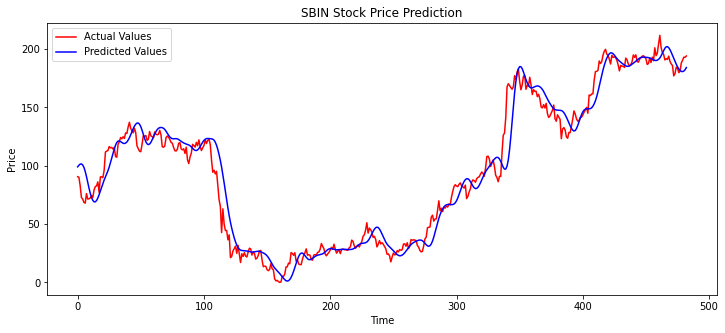

In [82]:
plt.figure(figsize=(12,5))
plt.plot(y_train, color='red', label='Actual Values')
plt.plot(y_train_pred, color='blue', label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('SBIN Stock Price Prediction')
plt.legend(loc='upper left')

Testing Plot

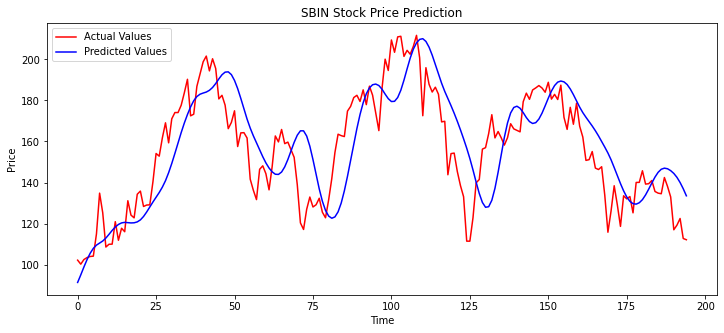

In [83]:
plt.figure(figsize=(12,5))
plt.plot(y_test, color='red', label='Actual Values')
plt.plot(y_pred, color='blue', label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('SBIN Stock Price Prediction')
plt.legend(loc='upper left')

# Technical Analysis

In [84]:
d = stock_df(stock_name, start_date, end_date)
df = d[['Open', 'High', 'Low', 'Close', 'Volume']]
df

,Open,High,Low,Close,Volume
Date,,,,,
2019-05-02,308.05,311.40,305.65,308.15,16640100
2019-05-03,309.00,311.80,308.80,310.00,12452689
2019-05-06,306.80,310.30,305.90,308.75,10639216
2019-05-07,310.70,313.40,303.75,305.45,15219845
2019-05-08,303.95,305.30,296.75,298.25,22103678
...,...,...,...,...,...
2022-06-13,454.00,454.05,442.10,445.85,13426836
2022-06-14,445.00,449.25,443.35,448.10,11351101
2022-06-15,448.95,455.45,448.60,451.35,9920926


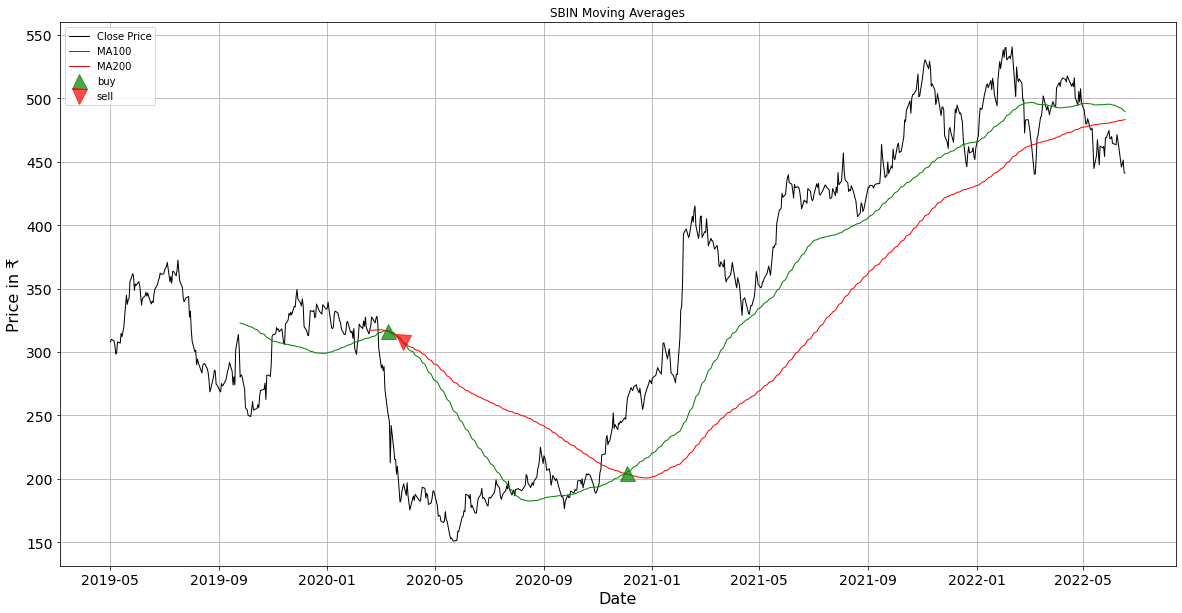

In [90]:
# Indicator 1 - Momentum
# Moving Averages
def moving_average(df, short_window = 100, long_window = 200):
    df['MA100'] = df['Close'].rolling(short_window).mean()
    df['MA200'] = df['Close'].rolling(long_window).mean()
    df['MA20'] = df['Close'].rolling(20).mean()
    df['Signal'] = 0
    df['Signal'] = np.where(df['MA100'] > df['MA200'], 1, 0)
    df['Position'] = df['Signal'].diff()

    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df['Close'].plot(color = 'k', lw = 1, label = 'Close Price')  
    df['MA100'].plot(color = 'g', lw = 1, label = 'MA100')
    df['MA200'].plot(color = 'r', lw = 1, label = 'MA200') 

    # plot 'buy' signals
    plt.plot(df[df['Position'] == 1].index, 
            df['MA100'][df['Position'] == 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df[df['Position'] == -1].index, 
            df['MA100'][df['Position'] == -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title('SBIN Moving Averages')
    plt.legend()
    plt.grid()
    plt.show()

moving_average(df)

In [86]:
# Indicator 2 - Momentum
# Relative Strength Index
rsi = RSIIndicator(df['Close'], 14).rsi()
def relative_strength_index(df, rsi):
    if(rsi[-7:].mean() > 80):
        print('Alert : Do Not buy this stock, market value exceeded 80%')
    if(rsi[-7:].mean() < 20):
        print('Alert : Do Not sell this stock, market value below 20%')
    else:
        if(rsi[-7:].mean() > 50):
            return 'Prefer Buy'
        elif(rsi[-7:].mean() < 50):
            return 'Prefer Sell'
        else:
            return 'Prefer Hold'
    
relative_strength_index(df, rsi)

'Prefer Sell'

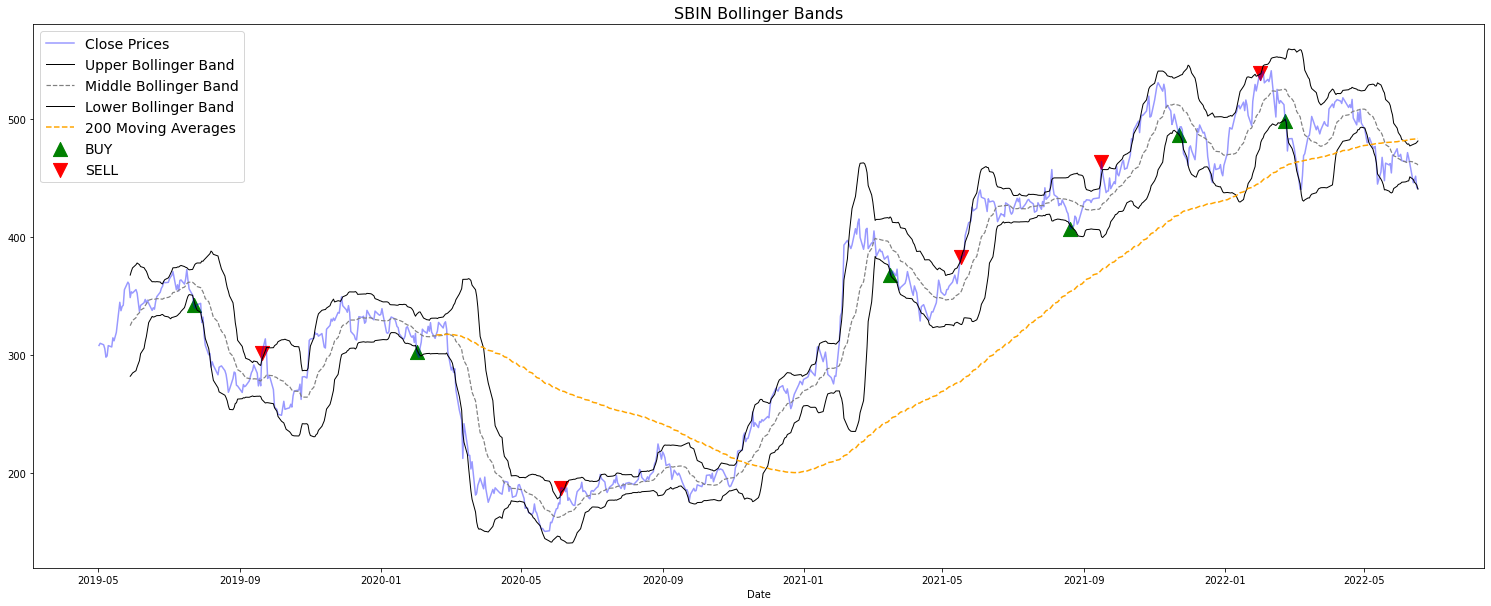

In [98]:
# Indicator - 3 Volatility
# Bollinger Bands
def bb(data, sma, window = 20):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(df['Close'], df['MA20'])

def bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = bb_strategy(df['Close'], df['lower_bb'], df['upper_bb'])
plt.figure(figsize=(26,10))
df['Close'].plot(label = 'Close Prices', alpha = 0.4, color = 'blue')
df['upper_bb'].plot(label = 'Upper Bollinger Band', linewidth = 1, color = 'black')
df['MA20'].plot(label = 'Middle Bollinger Band', linestyle = '--', linewidth = 1.2, color = 'grey')
df['lower_bb'].plot(label = 'Lower Bollinger Band', linewidth = 1, color = 'black')
df['MA200'].plot(label = '200 Moving Averages', linestyle = '--', linewidth = 1.5, color = 'orange')
plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('SBIN Bollinger Bands', fontsize = 16)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

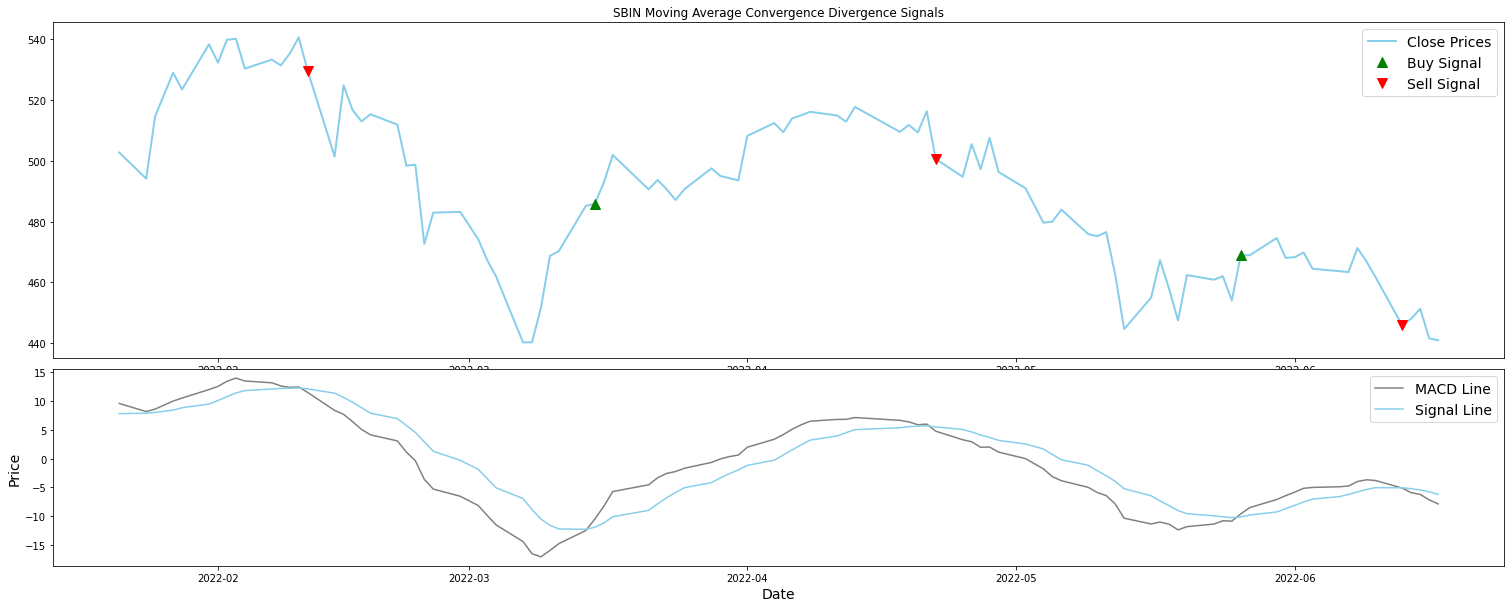

In [97]:
# Indicator - 4 Trend
# MACD
def get_macd(price, slow = 26, fast = 12, smooth = 9):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df


df_macd = get_macd(df['Close'])

def macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = macd_strategy(df['Close'], df_macd)

plt.figure(figsize=(26,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['Close'][-100:], color = 'skyblue', linewidth = 2, label = 'Close Prices')
ax1.plot(df.index[-100:], buy_price[-100:], marker = '^', color = 'green', markersize = 10, label = 'Buy Signal', linewidth = 0)
ax1.plot(df.index[-100:], sell_price[-100:], marker = 'v', color = 'r', markersize = 10, label = 'Sell Signal', linewidth = 0)
ax1.legend(fontsize = 14)
ax1.set_title('SBIN Moving Average Convergence Divergence Signals')
ax2.plot(df_macd['macd'][-100:], color = 'grey', linewidth = 1.5, label = 'MACD Line')
ax2.plot(df_macd['signal'][-100:], color = 'skyblue', linewidth = 1.5, label = 'Signal Line')
plt.legend(loc = 'upper right', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.show()

# for i in range(len(df_macd[-100:])):
    
#     if str(df_macd['hist'][:len(df_macd)-i])[0] == '-':
#         ax2.bar(df_macd.index[len(df_macd)-i], df_macd['hist'][len(df_macd)-i], color = 'green')
#     else:
#         ax2.bar(df_macd.index[len(df_macd)-i], df_macd['hist'][len(df_macd)-i], color = 'red')

Text(0.5, 1.0, 'SBIN Exponential Moving Averages')

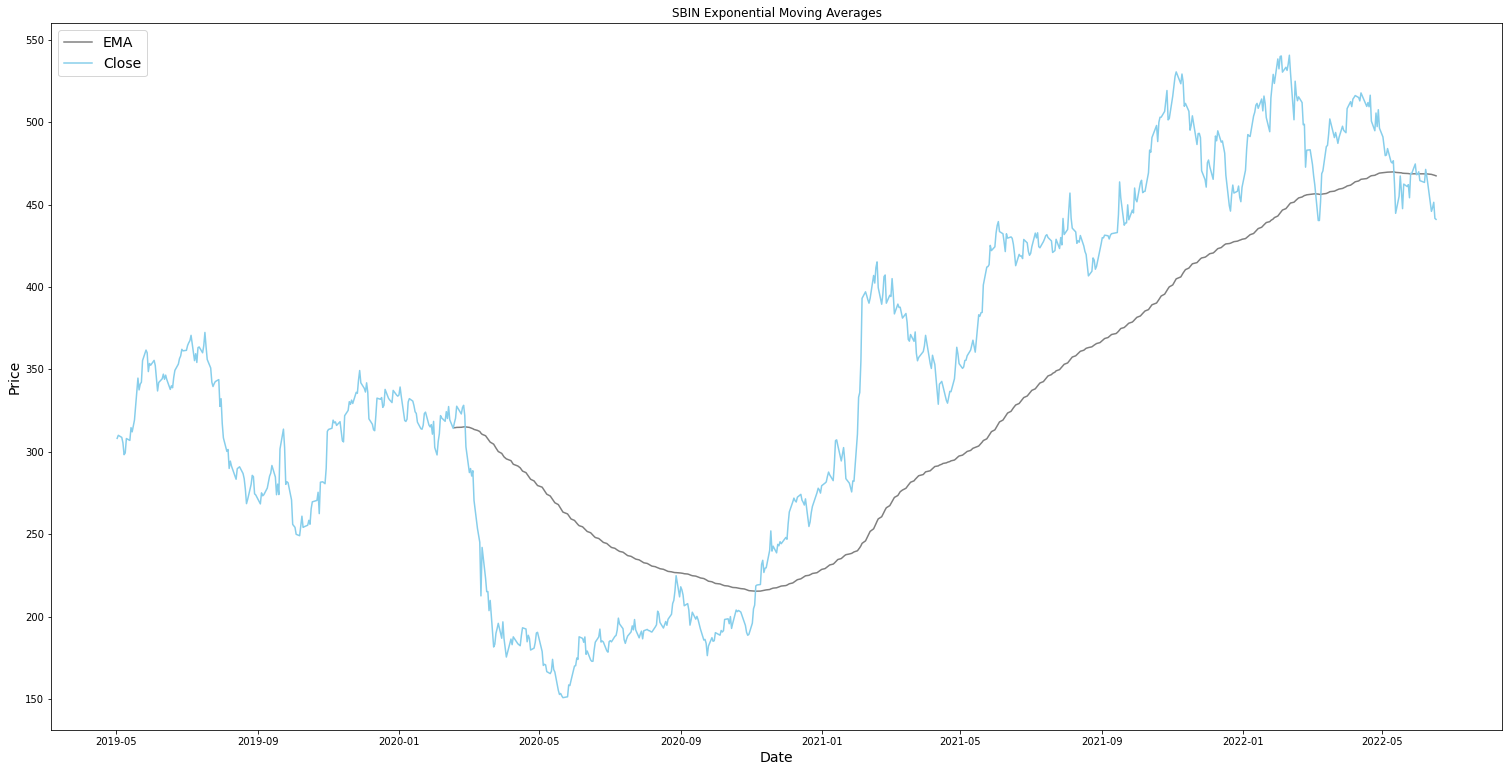

In [94]:
# Indicator - 5 Momentum
# Exponential Moving Averages
ema = EMAIndicator(df['Close'], 200)
df['EMA'] = ema.ema_indicator()
def addemasignal(df, backcandles):
    emasignal = [0]*len(df)
    for row in range(backcandles, len(df)):
        upt = 1
        dnt = 1
        for i in range(row-backcandles, row+1):

            if df.High[i]>=df.EMA[i]:
                dnt=0
            if df.Low[i]<=df.EMA[i]:
                upt=0

        if upt==1 and dnt==1:
            emasignal[row]=3
        elif upt==1:
            emasignal[row]=2
        elif dnt==1:
            emasignal[row]=1
    df['EMASignal'] = emasignal

addemasignal(df,6)
df.EMA.plot(color = 'grey', linewidth = 1.5, label = 'EMA', figsize = (26,13))
df.Close.plot(color = 'skyblue', linewidth = 1.5, label = 'Close')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('SBIN Exponential Moving Averages')